### DFRとVFRの未来の擾乱に対する計画収束速度で比較する

仮説: DFRで運行すると未来の擾乱に対する周りの人（自分の決定に影響を及ぼしうる人）の反応が瞬時にわかるため、VFRと比べた際に擾乱に対する収束速度が高まる。その結果として交通キャパシティが上昇する。

この仮説をシミュレーション実験によって確かめる。

#### 組むべき実験系
- ノイズは1個だけ（複数にも対応できるようにはしているが速度計算周りが怪しい）


In [23]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import sys
import io
import copy
from tqdm.notebook import tqdm  # tqdm.notebookをインポート
from IPython.display import display, HTML



sys.path.append("../")
from models import Cars, ReservationTable, DFRSimulation, VFRSimulation
from utils import check_multiple_noise_effect, validate_with_ttc, generate_arrival_times_poisson

# ↑↑↑↑↑↑↑↑↑この部分は別セルでも良い↑↑↑↑↑↑↑↑↑

# 初期設定（独立変数群）
CAR_NUM = 200 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 1500 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
MAX_SPEED = 30 # 秒速[m/s]として定義
MAX_ACC = 3 # m/s^sで定義, maxは0.3gにした
TIME_STEP = 0.1
# TOTAL_TIME = 100 # シミュレーション時間

# 研究用のパラメータ
TTC = 1.5 #車間時間を暫定的に定義
COMMUNICATION_SPEED = 0.2
LAMBDA = 2.0 # 台数密度を車間時間として定義

# ノイズ関連のパラメ-タ
NOISE_FORECAST_TIME = 10 # 何秒後の擾乱を前もって知らせるか. 
NOISE_PERIOD = 5
NOISE_FREQUENCY = 10

# arrival_times = generate_arrival_times_poisson(LAMBDA, TTC, CAR_NUM)
arrival_times = [1.5, 3.0, 4.5, 7.563477139960142, 9.063477139960142, 11.025988545386186, 12.525988545386186, 14.025988545386186, 16.08115161025966, 17.58115161025966, 19.08115161025966, 20.633498086795584, 28.409015075879168, 29.909015075879168, 31.409015075879168, 34.77497933095756, 37.283089688793574, 38.783089688793574, 40.283089688793574, 41.783089688793574, 43.283089688793574, 46.55243845302921, 48.05243845302921, 49.55243845302921, 51.05243845302921, 54.214572940250356, 56.193749837972554, 60.019833340172156, 61.79215271889568, 64.06392497492322, 66.83717136399932, 69.05754444327698, 70.55754444327698, 73.753188797416, 75.253188797416, 76.753188797416, 78.253188797416, 79.753188797416, 81.253188797416, 82.753188797416, 84.80421240066002, 86.30421240066002, 95.34647804549957, 97.35700582363997, 99.73574894268882, 101.23574894268882, 102.73574894268882, 105.80530487976331, 108.74078155136968, 112.2090001662115, 113.7090001662115, 115.2090001662115, 121.33763978771175, 124.72426515665151, 126.22426515665151, 127.72426515665151, 129.2242651566515, 130.7242651566515, 132.2242651566515, 134.13264869465678, 135.63264869465678, 138.45904248164558, 139.95904248164558, 141.45904248164558, 142.95904248164558, 145.49572998847984, 147.41111869094516, 148.91111869094516, 150.41111869094516, 155.2734665753022, 156.7734665753022, 158.2734665753022, 159.7734665753022, 162.38428924574845, 163.88428924574845, 165.5579093312719, 168.09131800799852, 169.59131800799852, 175.21531409877724, 176.71531409877724, 179.38972786315784, 180.88972786315784, 183.21896729953312, 185.398022321378, 186.898022321378, 188.6075225841189, 190.1075225841189, 191.6075225841189, 193.1075225841189, 194.6075225841189, 196.2047721081033, 199.50140402527484, 201.00140402527484, 202.50140402527484, 204.00140402527484, 223.71728292010113, 225.21728292010113, 227.54176137082453, 229.22076739788486, 231.66221520326815, 233.1976901611816, 234.6976901611816, 236.23899605895983, 237.73899605895983, 239.23899605895983, 240.73899605895983, 242.23899605895983, 243.73899605895983, 245.23899605895983, 246.73899605895983, 249.14148746149115, 255.57584816993264, 258.5303981217387, 260.0303981217387, 261.5303981217387, 263.0303981217387, 267.68590834844855, 270.44043646404805, 275.01805518644426, 278.26046143316506, 284.3615567253788, 285.8615567253788, 290.4075705482912, 293.363318217826, 296.8895015004478, 299.288936130439, 300.788936130439, 302.288936130439, 305.4193493882974, 308.0153092366336, 311.99153356379, 318.1551217205168, 322.3381048061717, 323.8381048061717, 327.22133910906126, 328.72133910906126, 333.4884428225549, 338.3391389304554, 339.8391389304554, 341.3391389304554, 343.7029486976613, 345.2029486976613, 346.782568230944, 348.282568230944, 349.782568230944, 351.282568230944, 352.782568230944, 355.1182733831613, 356.6182733831613, 358.1182733831613, 359.79599363404014, 363.3197082024687, 364.8197082024687, 369.2401749688984, 370.7401749688984, 372.2401749688984, 373.7401749688984, 375.2401749688984, 378.68571072268344, 380.18571072268344, 383.2328357414169, 384.7328357414169, 386.58927195347826, 389.0324483328645, 392.81941134843834, 394.34498350048256, 398.1028914825772, 400.0891188939415, 403.10890512865956, 410.3972874699586, 413.1650070598264, 414.6650070598264, 416.1650070598264, 417.6650070598264, 419.2791251966493, 420.7791251966493, 424.59406792015665, 431.0086016207741, 432.5086016207741, 436.6999431110639, 438.1999431110639, 439.8496603879615, 441.3496603879615, 446.5819412885419, 450.61312930050264, 453.30126079442596, 454.80126079442596, 456.37991937872243, 457.87991937872243, 459.9726610315647, 461.4726610315647, 463.78702708927995, 465.28702708927995, 469.29413038608817, 470.79413038608817, 475.159399070352, 476.98379055194636, 481.06007681445976, 482.56007681445976, 484.06007681445976]

car_params = {"v_mean":MEAN_SPEED, "v_max": MAX_SPEED, "a_max":MAX_ACC, "a_min":MAX_ACC}

def create_noise(current_time):
    if current_time % NOISE_FREQUENCY == 0 and current_time > 0:
        # ノイズを未来に発生させる（この瞬間、だと偶然ハマる車が出てきしまう）
        return {"x": [1000, 1020], "t": [current_time + NOISE_FORECAST_TIME, current_time + NOISE_FORECAST_TIME + NOISE_PERIOD]}
    # この場合はノイズを発生させない.
    return None

def register_initial_eta(cars):
    for idx, car in enumerate(CARS):
        desired_eta_list = car.create_desired_eta(WAYPOINTS)
        is_valid = reservation_table.validate(desired_eta_list)
        if is_valid:
            reservation_table.register(desired_eta_list)
        else:
            calibration_info = {"desired_list": desired_eta_list}
            calibrated_list, _ = reservation_table.calibrate_list(**calibration_info)
            # print(calibrated_list)
            # print()
            reservation_table.register(calibrated_list)
            car.my_list = calibrated_list

print(arrival_times[-1]-1)
print(arrival_times)
TOTAL_TIME = min(arrival_times[-1]-1, 800)

483.06007681445976
[1.5, 3.0, 4.5, 7.563477139960142, 9.063477139960142, 11.025988545386186, 12.525988545386186, 14.025988545386186, 16.08115161025966, 17.58115161025966, 19.08115161025966, 20.633498086795584, 28.409015075879168, 29.909015075879168, 31.409015075879168, 34.77497933095756, 37.283089688793574, 38.783089688793574, 40.283089688793574, 41.783089688793574, 43.283089688793574, 46.55243845302921, 48.05243845302921, 49.55243845302921, 51.05243845302921, 54.214572940250356, 56.193749837972554, 60.019833340172156, 61.79215271889568, 64.06392497492322, 66.83717136399932, 69.05754444327698, 70.55754444327698, 73.753188797416, 75.253188797416, 76.753188797416, 78.253188797416, 79.753188797416, 81.253188797416, 82.753188797416, 84.80421240066002, 86.30421240066002, 95.34647804549957, 97.35700582363997, 99.73574894268882, 101.23574894268882, 102.73574894268882, 105.80530487976331, 108.74078155136968, 112.2090001662115, 113.7090001662115, 115.2090001662115, 121.33763978771175, 124.72426

In [24]:
# ここからDFRのシミュレーション
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0
CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]

reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})

# 各車がETAを決める部分
register_initial_eta(CARS)

In [25]:
simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                          reservation_table = reservation_table, create_noise=create_noise, COMMUNICATION_SPEED=COMMUNICATION_SPEED, DENSITY=LAMBDA)
simulation.conduct_simulation(should_plot=False, plot_start=229, plot_finish=300)

Simulation Progress DFR, density=2.0:   0%|          | 0/4830 [00:00<?, ?it/s]

L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った
L271: 止まる方に入った


{'time': 11.5, 'v_mean': 20.0, 'density': 4.0, 'event_flg': None, 'flow_sum': 120.0, 'flow': 80.0, 'v_mean_before_noise': 19.996667222129645, 'v_mean_after_noise': 0.0, 'rho_before_noise': 6.0, 'rho_after_noise': 0.0, 'flow_before_noise': 119.98000333277787, 'flow_after_noise': 0.0}
   time  v_mean   density event_flg  flow_sum       flow  v_mean_before_noise  \
0   1.5    20.0  0.666667      None      20.0  13.333333                  NaN   
1   1.6    20.0  0.666667      None      20.0  13.333333                  NaN   
2   1.7    20.0  0.666667      None      20.0  13.333333                  NaN   
3   1.8    20.0  0.666667      None      20.0  13.333333                  NaN   
4   1.9    20.0  0.666667      None      20.0  13.333333                  NaN   

   v_mean_after_noise  rho_before_noise  rho_after_noise  flow_before_noise  \
0                 NaN               NaN              NaN                NaN   
1                 NaN               NaN              NaN               

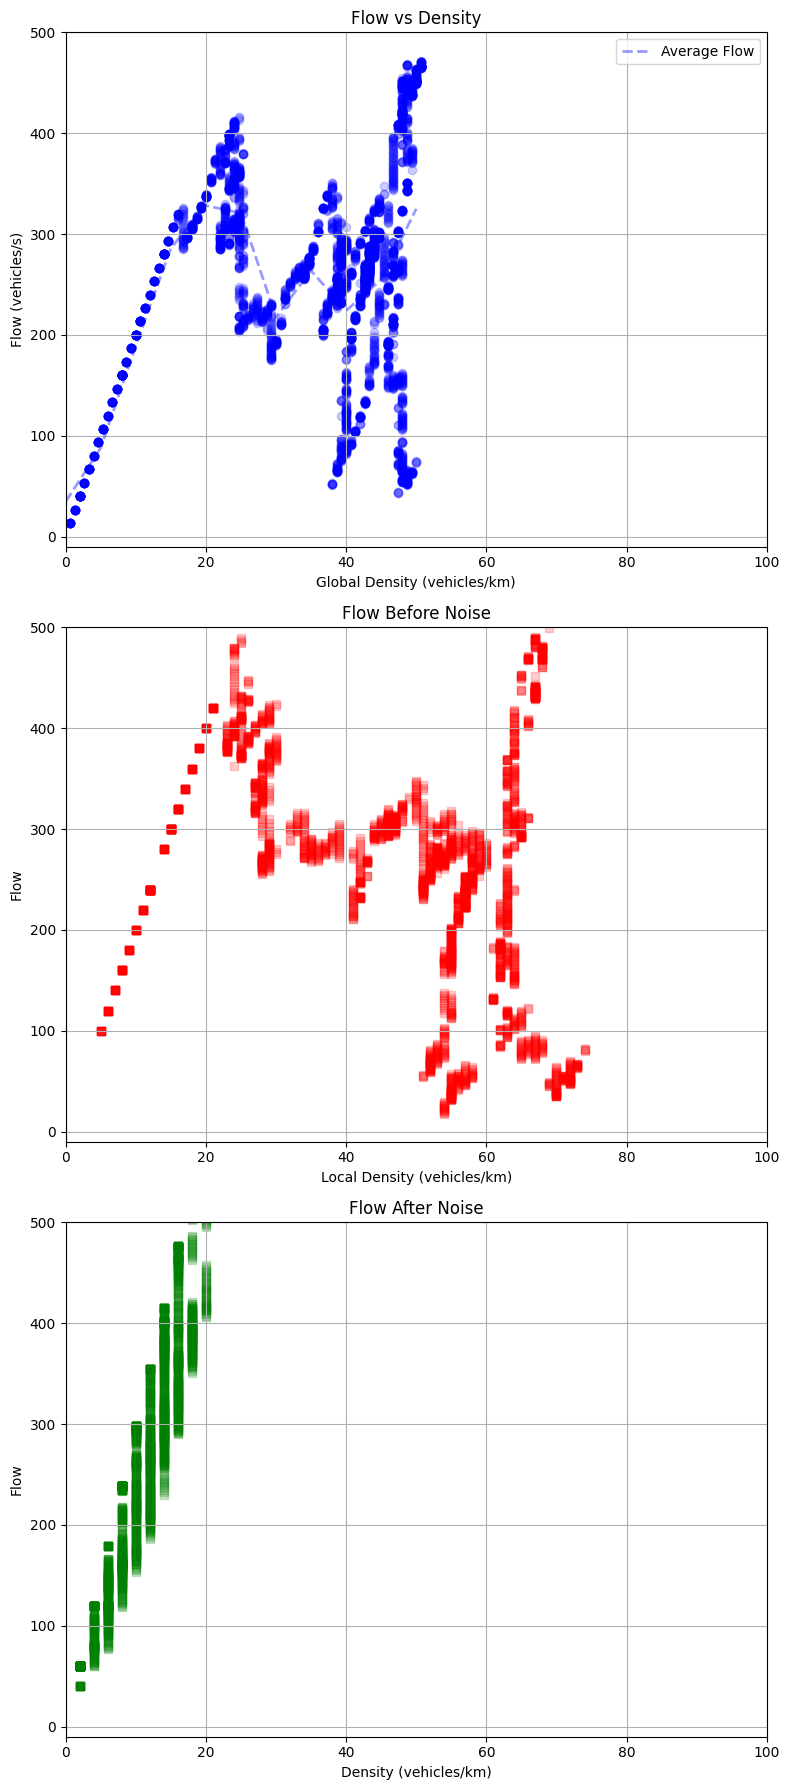

In [32]:
cars = simulation.CARS
v_mean_log = simulation.v_mean_log
car_1 = cars[68]
print(v_mean_log[100])

def draw_fd_before_and_after(v_mean_log, density_increment, xmax=200, ymax=1000):
    df = pd.DataFrame(v_mean_log)
    print(df.head())
    df_bn = df[df["v_mean_before_noise"] > 0] # df before noise
    df_an = df[df["v_mean_after_noise"] > 0] # df after noise


    # ここから描画開始
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 18))
    
    # 1つ目のグラフ (flow_total vs density)
    # ax1.plot(data['local_density'], data['flow'], marker='s', linestyle='--', color='b')
    ax1.scatter(df['density'], df['flow'], marker='o', color='b', alpha=0.2)

    # 平均線を追加
    density_points = np.arange(0, 800, 5)
    mean_flow = [df[(df['density'] >= d - density_increment) & (df['density'] < d + density_increment)]['flow'].mean()
                 for d in density_points]
    ax1.plot(density_points, mean_flow, color='blue', linestyle='--', linewidth=2, label='Average Flow', alpha=0.4)
    
    ax1.legend()
    ax1.set_title('Flow vs Local Density')
    ax1.set_xlabel('Global Density (vehicles/km)')
    ax1.set_ylabel('Flow (vehicles/s)')
    ax1.set_title('Flow vs Density')
    ax1.grid(True)
    ax1.set_xlim(0, xmax)  # x軸の範囲を設定
    ax1.set_ylim(-10, ymax) 
    
    # 2つ目のグラフ (ノイズ手前)
    ax2.scatter(df_bn['rho_before_noise'], df_bn['flow_before_noise'], marker='s', color='r', alpha=0.2)
    ax2.set_xlabel('Local Density (vehicles/km)')
    ax2.set_ylabel('Flow')
    ax2.set_title('Flow Before Noise')  
    ax2.grid(True)
    ax2.set_xlim(0, xmax)  # x軸の範囲を設定
    ax2.set_ylim(-10, ymax) 
    

    # 3つ目のグラフ (ノイズ後)
    ax3.scatter(df_an['rho_after_noise'], df_an['flow_after_noise'], marker='s', color='green', alpha=0.2)
    ax3.set_xlabel('Density (vehicles/km)')
    ax3.set_ylabel('Flow')
    ax3.set_title('Flow After Noise')  
    ax3.grid(True)
    ax3.set_xlim(0, xmax)  # x軸の範囲を設定
    ax3.set_ylim(-10, ymax) 
    
    
    
    # レイアウトの調整と表示
    plt.tight_layout()
    plt.show()

draw_fd_before_and_after(v_mean_log, 3, xmax=100, ymax=500)

In [31]:
v_mean_log = simulation.v_mean_log
df = pd.DataFrame(v_mean_log)
df_bn = df[df["v_mean_before_noise"] > 0] # df before noise
df_an = df[df["v_mean_after_noise"] > 0] # df after noise

def test(df):
    rho_thresh_min = 40
    rho_thresh_max = 60
    flow_min = 300

    # headwayが最大値と最小値の範囲内にある行をフィルタリング
    df_filtered = df[(df['rho_before_noise'] >= rho_thresh_min) & (df['rho_before_noise'] <= rho_thresh_max) & (df['flow_before_noise'] <= flow_min)]
    print(df_filtered.head())
    print(f"この条件での行数: {len(df_filtered)}行")

    # data = process_headway_data(headway_df)
    # print("======Flow とlocal_densityで整理したもの====")
    # data_filtered = data[(data["local_density"] >=  300) & (data["v_mean"] > 5)]
    # data_length = len(data_filtered)
    # print(f"この条件での行数: {data_length}行")
    # if data_length < 20:
    #     print(data_filtered.head(data_length))


test(df_bn)

       time    v_mean    density event_flg    flow_sum        flow  \
1485  150.0  7.831488  29.333333      None  344.585452  229.723635   
1486  150.1  7.795124  29.333333      None  342.985452  228.656968   
1487  150.2  7.758760  29.333333      None  341.385452  227.590302   
1488  150.3  7.201987  28.666667      None  309.685452  206.456968   
1489  150.4  7.157801  28.666667      None  307.785452  205.190302   

      v_mean_before_noise  v_mean_after_noise  rho_before_noise  \
1485             6.790874           22.043591              41.0   
1486             6.746973           22.110236              41.0   
1487             6.703071           22.176880              41.0   
1488             6.651853           18.467175              41.0   
1489             6.600635           18.567125              41.0   

      rho_after_noise  flow_before_noise  flow_after_noise  
1485              6.0         278.425844        132.261549  
1486              6.0         276.625888        132.66

[{'time': 2.6, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 2.0}, {'time': 2.7, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 4.0}, {'time': 2.8000000000000003, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 6.0}, {'time': 2.9000000000000004, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 8.0}, {'time': 3.0, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 10.0}, {'time': 3.1, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 12.0}, {'time': 3.2, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 14.0}, {'time': 3.3000000000000003, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 16.0}, {'time': 3.4000000000000004, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 18.0}, {'time': 3.5, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 20.0}]
     local_density     v_mean          flow
0              1.0  27.132625  2.713262e+01
1              2.0  13.000513  2.600103e+01
2              3.0  19.486694  5.846008e+01
3              4.0  15.1004

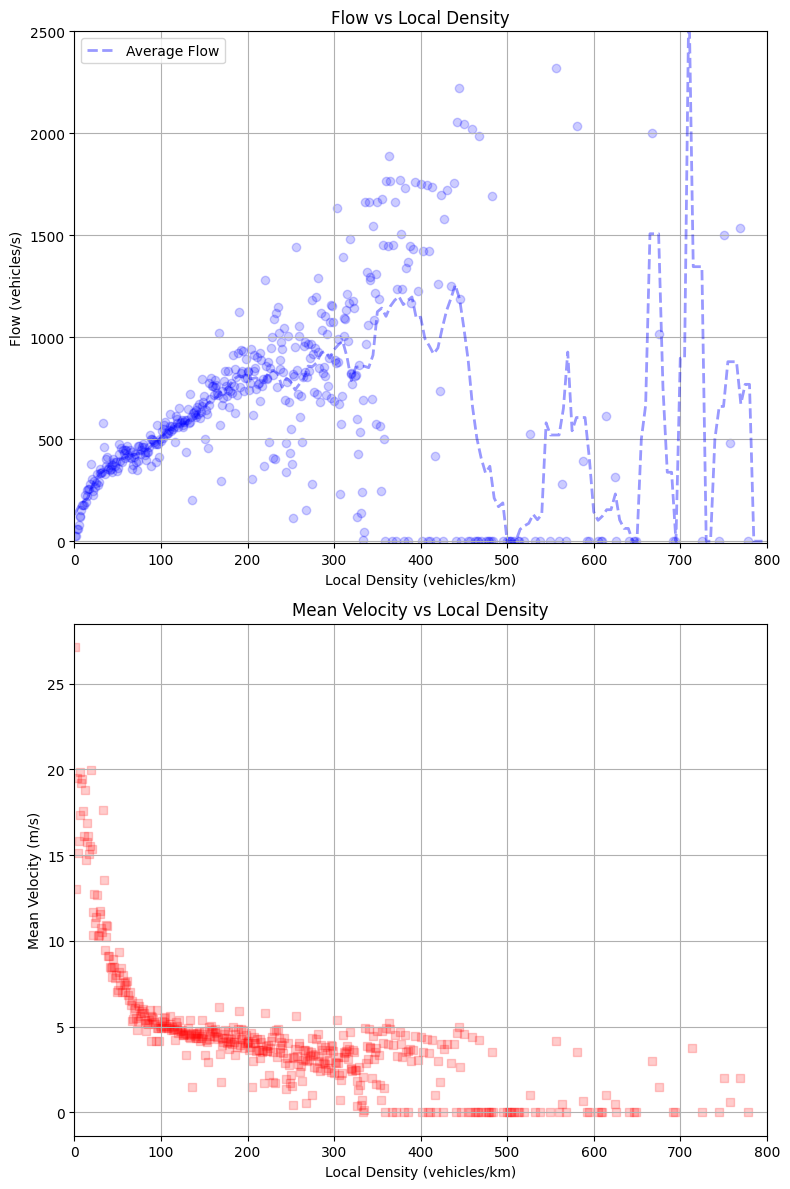

In [7]:
def process_headway_data(df):
    # 1. headwayの逆数 * 1000 (=1kmあたりの密度)をlocal_densityとしてデータフレームのカラムに追加
    df['local_density'] = 1000 / df['headway']

    # 2. local_densityごとに平均をとる
    # まずはlocal_densityを整数に丸めて、L-0.5 < local_density < L+0.5 の範囲にあるものを同じグループとする
    df['density_group'] = df['local_density'].round(0)

    # density_groupごとにv_xの平均を計算
    df_grouped = df.groupby('density_group')['v_x'].mean().reset_index()

    # カラム名を適切に変更
    df_grouped.rename(columns={'v_x': 'v_mean', 'density_group': 'local_density'}, inplace=True)

    # 3. local_densityとv_meanをかけたflowという値をdf_newに新たなカラムとして追加
    df_grouped['flow'] = df_grouped['local_density'] * df_grouped['v_mean']

    # 結果を返す
    return df_grouped

def show_fd(simulation):
    headway_list = simulation.headway_log
    print(simulation)
    print(headway_list[:10])
    headway_df = pd.DataFrame(headway_list)
    data = process_headway_data(headway_df)
    print(data)
    data_filtered = data[(data["local_density"] >=  300) & (data["v_mean"] > 5)]
    data_length = len(data_filtered)
    print(f"この条件での行数: {data_length}行")
    # 2つのグラフを縦に並べて描画
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
    
    # 1つ目のグラフ (flow vs local_density)
    # ax1.plot(data['local_density'], data['flow'], marker='s', linestyle='--', color='b')
    ax1.scatter(data['local_density'], data['flow'], marker='o', color='b', alpha=0.2)

    # 平均線を追加
    density_points = np.arange(0, 800, 5)
    mean_flow = [data[(data['local_density'] >= d - 15) & (data['local_density'] < d + 15)]['flow'].mean()
                 for d in density_points]
    ax1.plot(density_points, mean_flow, color='blue', linestyle='--', linewidth=2, label='Average Flow', alpha=0.4)
    
    ax1.legend()
    ax1.set_title('Flow vs Local Density')
    ax1.set_xlabel('Local Density (vehicles/km)')
    ax1.set_ylabel('Flow (vehicles/s)')
    ax1.grid(True)
    ax1.set_xlim(0, 800)  # x軸の範囲を設定
    ax1.set_ylim(-10, 2500)  # x軸の範囲を設定
    
    # 2つ目のグラフ (v_mean vs local_density)
    # ax2.plot(data['local_density'], data['v_mean'], linestyle='--', color='r')
    ax2.scatter(data['local_density'], data['v_mean'], marker='s', color='r', alpha=0.2)
    ax2.set_title('Mean Velocity vs Local Density')
    ax2.set_xlabel('Local Density (vehicles/km)')
    ax2.set_ylabel('Mean Velocity (m/s)')
    ax2.grid(True)
    ax2.set_xlim(0, 800)  # x軸の範囲を設定
    
    
    # レイアウトの調整と表示
    plt.tight_layout()
    plt.show()

show_fd(simulation)

In [58]:
# 個別解析用
df = headway_df
filtered_df = df[df["v_x"] <3]
print(filtered_df.shape)

print(filtered_df)

(0, 7)
Empty DataFrame
Columns: [time, headway, v_x, car_idx, xcoor, local_density, density_group]
Index: []


In [17]:
# ここからはまとめてシミュレーションするためのコード

DENSITY_LIST = [10, 4, 3, 2.4, 1.8]
NOISE_FORECAST_TIME_LIST = [5]
NOISE_PERIOD_LIST = [5]
COMMU_SPEED_LIST = [0.2]
TOTAL_TIME=200
results = []
arrival_time_log = []
import sys
import io
from collections import defaultdict

def process_headway_data(df):
    # 1. headwayの逆数 * 1000 (=1kmあたりの密度)をlocal_densityとしてデータフレームのカラムに追加
    df['local_density'] = 1000 / df['headway']

    # 2. local_densityごとに平均をとる
    # まずはlocal_densityを整数に丸めて、L-0.5 < local_density < L+0.5 の範囲にあるものを同じグループとする
    df['density_group'] = df['local_density'].round(0)

    # density_groupごとにv_xの平均を計算
    df_grouped = df.groupby('density_group')['v_x'].mean().reset_index()

    # カラム名を適切に変更
    df_grouped.rename(columns={'v_x': 'v_mean', 'density_group': 'local_density'}, inplace=True)

    # 3. local_densityとv_meanをかけたflowという値をdf_newに新たなカラムとして追加
    df_grouped['flow'] = df_grouped['local_density'] * df_grouped['v_mean']

    # 結果を返す
    return df_grouped

all_headway_dfs = []    
total_iterations = len(NOISE_FORECAST_TIME_LIST) * len(NOISE_PERIOD_LIST) * len(COMMU_SPEED_LIST) * len(DENSITY_LIST)
with tqdm(total=total_iterations) as pbar:
    for noise_forecast_time in NOISE_FORECAST_TIME_LIST:
        for noise_period in NOISE_PERIOD_LIST:
            for communication_speed in COMMU_SPEED_LIST:
                for idx, density in enumerate(DENSITY_LIST):
                    print(f"Running simulation with density={density}, noise_forecast_time={noise_forecast_time}, noise_period={noise_period}, communication_speed={communication_speed}")
                
                    arrival_times = generate_arrival_times(CAR_NUM, density, TOTAL_TIME)
                    arrival_times.append(TOTAL_TIME + TTC +0.2)
                    CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
                              for index, time in enumerate(arrival_times)]
                    arrival_time_log.append({"density": density, "arrival_times":arrival_times})

                    def create_noise(current_time):
                        if current_time % NOISE_FREQUENCY == 0 and current_time > 0:
                            # ノイズを未来に発生させる（この瞬間、だと偶然ハマる車が出てきしまう）
                            return {"x": [520, 550], "t": [current_time + noise_forecast_time, current_time + noise_forecast_time + noise_period]}
                        # この場合はノイズを発生させない.
                        return None
                
                    # まずはDFR
                    # 標準出力を無効化
                    original_stdout = sys.stdout
                    sys.stdout = io.StringIO()
                    reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
                    register_initial_eta(CARS)
                
                    dfr_simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                                          reservation_table = reservation_table, DENSITY=density, COMMUNICATION_SPEED=communication_speed, create_noise=create_noise)
                    try:
                        dfr_simulation.conduct_simulation(should_plot=False)
                        headway_list = dfr_simulation.headway_log
                        headway_df = pd.DataFrame(headway_list)
                        headway_df = process_headway_data(headway_df)
                        # 追加カラムを追加する
                        headway_df['density'] = density
                        headway_df['noise_forecast_time'] = noise_forecast_time
                        headway_df['noise_period'] = noise_period
                        headway_df['communication_speed'] = communication_speed
                
                        # 結果をリストに追加
                        all_headway_dfs.append(headway_df)
                        
                
                    except:
                        sys.stdout = original_stdout
                        print(arrival_times)
                        
                    finally:
                        # 標準出力を元に戻す
                        sys.stdout = original_stdout
                    pbar.update(1)
                    
final_headway_df = pd.concat(all_headway_dfs, ignore_index=True)
               

  0%|          | 0/5 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/2000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=4:   0%|          | 0/2000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=3:   0%|          | 0/2000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=2.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=1.8:   0%|          | 0/2000 [00:00<?, ?it/s]

[0.9958288129982859, 5.287233129036741, 8.59464779137927, 12.41331846102123, 15.35178948508543, 18.089027551552434, 21.686473194033372, 25.529885585952535, 28.738588920141332, 31.378984378605875, 34.15069324094699, 38.65461736127613, 42.198918455182785, 44.82187773076833, 47.74355633196187, 51.248831946417724, 55.803139174787816, 59.229418797468156, 62.999513051941044, 66.78782028356221, 71.02697798225786, 74.26037069872682, 78.09280366333712, 81.04959819369992, 83.92590031213548, 87.6810002060757, 91.15995049508086, 95.57577501493115, 99.71979174670052, 103.61323987259884, 107.34415195924623, 110.17723676263368, 114.31655631511981, 118.61473746052114, 122.22498233706457, 126.35813425375207, 130.16457913202967, 134.61603085666923, 138.30915595700654, 141.34660409333318, 144.99197966479127, 148.8968522850624, 152.6395259702966, 156.64599365656315, 160.03272764553176, 163.6837266270248, 166.38981340089035, 169.01848494283718, 171.76510882618564, 175.46834644834394, 178.61525117429943, 18

138


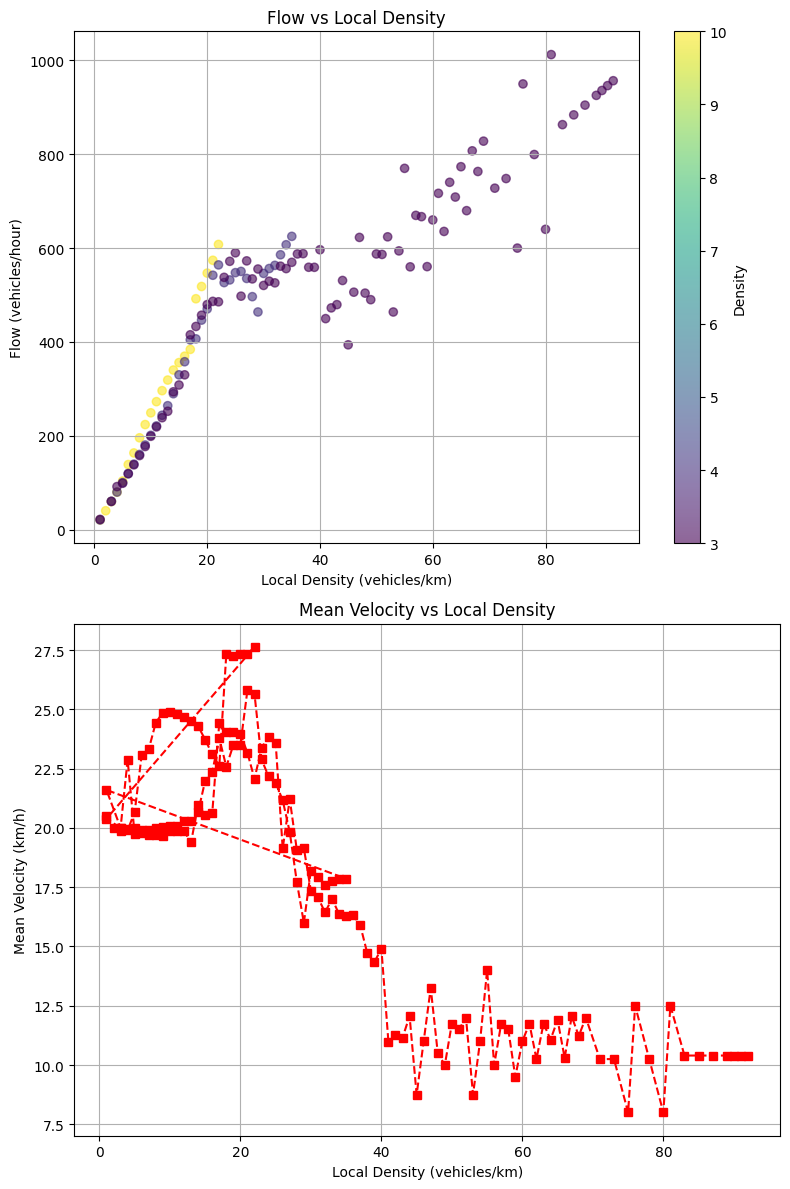

In [23]:
# 全てのheadway_dfを結合
final_headway_df = pd.concat(all_headway_dfs, ignore_index=True)
# final_headway_dfを出力
print(len(final_headway_df))
final_headway_df.to_csv("density.csv")

def plot_fd(df):
    # local_densityが0以上のデータを抽出
    data = df[df['local_density'] >= 0]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
    
    # 1つ目のグラフ (flow vs local_density)
    scatter = ax1.scatter(data['local_density'], data['flow'], c=data['density'], cmap='viridis', marker='o', alpha=0.6)
    ax1.set_title('Flow vs Local Density')
    ax1.set_xlabel('Local Density (vehicles/km)')
    ax1.set_ylabel('Flow (vehicles/hour)')
    ax1.grid(True)
    
    # カラーバー（densityに基づいて色を変える）
    cbar = fig.colorbar(scatter, ax=ax1)
    cbar.set_label('Density')

    
    # 2つ目のグラフ (v_mean vs local_density)
    ax2.plot(data['local_density'], data['v_mean'], marker='s', linestyle='--', color='r')
    ax2.set_title('Mean Velocity vs Local Density')
    ax2.set_xlabel('Local Density (vehicles/km)')
    ax2.set_ylabel('Mean Velocity (km/h)')
    ax2.grid(True)
    
    # レイアウトの調整と表示
    plt.tight_layout()
    plt.show()

plot_fd(final_headway_df)

### 続いて同じ条件でVFRを試す

arrival_timeやTTC、ノイズの発生タイミングはそのまま引き継ぐ. 


In [5]:
vfr_simulation = VFRSimulation(TOTAL_TIME = 500, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=simulation, car_params=car_params)
vfr_simulation.conduct_simulation(should_plot=False)

Simulation Progress VFR:   0%|          | 0/4283 [00:00<?, ?it/s]

In [6]:
cars = vfr_simulation.CARS
car_front = cars[1]
car_back = cars[2]
print(car_front.xcorList[-10:-1])
print(car_front.is_crossing)
def create_v_list(car):
    vList = []
    for i, xcor in enumerate(car.xcorList):
        if i >= len(car.xcorList)-1:
            continue
        v = car.xcorList[int(i+1)] - xcor
        vList.append(v / TIME_STEP)
    return vList

vList = create_v_list(car_front)
print(vList[-10:-1])
v_mean_log = vfr_simulation.v_mean_log
max_flow_sum = max(item['flow_sum'] for item in v_mean_log)
print(max_flow_sum)

[1473.1321153718538, 1476.1321153718538, 1479.1321153718538, 1482.1321153718538, 1485.1321153718538, 1488.1321153718538, 1491.1321153718538, 1494.1321153718538, 1497.1321153718538]
False
[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0]
482.26039467201366


   lambda    flow type  calc_time[s]  ID_simulation
0    10.0  200.00  dfr           NaN            NaN
1     5.0  376.17  dfr           NaN            NaN
2     1.5  622.00  dfr           NaN            NaN
3     3.0  461.00  dfr           NaN            NaN
4     4.0  515.00  dfr           NaN            NaN


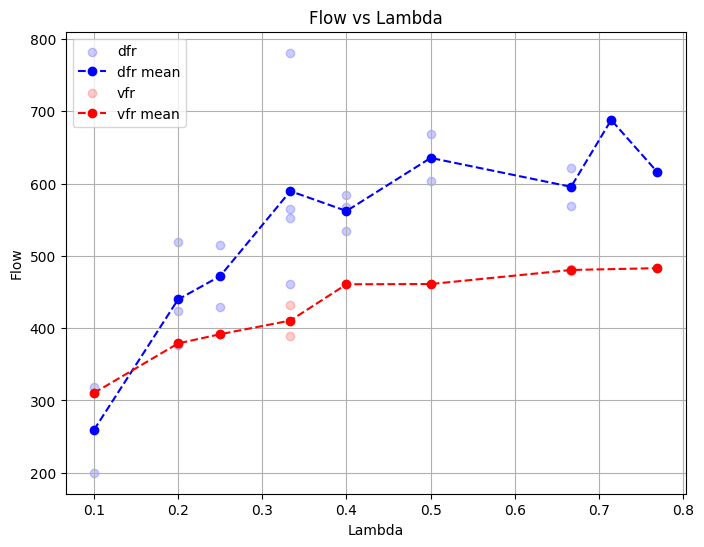

In [7]:
def plot_flow_vs_lambda_inverse(file_path):
    # CSVファイルを読み込む
    df = pd.read_csv(file_path)
    print(df.head())

    # lambdaの逆数を計算
    df['lambda_inverse'] = 1 / df['lambda']

    # vfr と dfr で異なる色を使ってプロット
    plt.figure(figsize=(8, 6))

    # dfrタイプのプロット
    dfr_data = df[df['type'] == 'dfr']
    dfr_grouped = dfr_data.groupby('lambda_inverse').agg({'flow': 'mean'}).reset_index()
    plt.scatter(dfr_data['lambda_inverse'], dfr_data['flow'], color='blue', label='dfr', alpha=0.2)
    plt.plot(dfr_grouped['lambda_inverse'], dfr_grouped['flow'], color='blue', marker='o', linestyle='--', label='dfr mean')

    # vfrタイプのプロット
    vfr_data = df[df['type'] == 'vfr']
    vfr_grouped = vfr_data.groupby('lambda_inverse').agg({'flow': 'mean'}).reset_index()
    plt.scatter(vfr_data['lambda_inverse'], vfr_data['flow'], color='red', label='vfr', alpha=0.2)
    plt.plot(vfr_grouped['lambda_inverse'], vfr_grouped['flow'], color='red', marker='o', linestyle='--', label='vfr mean')

    # グラフの装飾
    plt.xlabel('Lambda')
    plt.ylabel('Flow')
    plt.title('Flow vs Lambda')
    plt.legend()
    plt.grid(True)

plot_flow_vs_lambda_inverse("./result.csv")

In [8]:
def show_fd(dfr_simulation, vfr_simulation):
    # dfr_simulationの処理
    dfr_headway_list = dfr_simulation.headway_log
    dfr_headway_df = pd.DataFrame(dfr_headway_list)
    dfr_data = process_headway_data(dfr_headway_df)

    # vfr_simulationの処理
    vfr_headway_list = vfr_simulation.headway_log
    vfr_headway_df = pd.DataFrame(vfr_headway_list)
    vfr_data = process_headway_data(vfr_headway_df)

    # 2つのグラフを縦に並べて描画
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
    
    # 1つ目のグラフ (flow vs local_density)
    # dfr_simulationのデータを青色でプロット
    ax1.scatter(dfr_data['local_density'], dfr_data['flow'], marker='o', color='b', alpha=0.2, label='DFR')
    # vfr_simulationのデータを赤色でプロット
    ax1.scatter(vfr_data['local_density'], vfr_data['flow'], marker='o', color='r', alpha=0.2, label='VFR')
    ax1.set_title('Flow vs Local Density')
    ax1.set_xlabel('Local Density (vehicles/km)')
    ax1.set_ylabel('Flow (vehicles/s)')
    ax1.grid(True)
    ax1.set_xlim(0, 400)  # x軸の範囲を設定
    ax1.set_ylim(-10, 2500)  # y軸の範囲を設定
    ax1.legend()

    # 2つ目のグラフ (v_mean vs local_density)
    # dfr_simulationのデータを青色でプロット
    ax2.scatter(dfr_data['local_density'], dfr_data['v_mean'], marker='s', color='b', alpha=0.2, label='DFR')
    # vfr_simulationのデータを赤色でプロット
    ax2.scatter(vfr_data['local_density'], vfr_data['v_mean'], marker='s', color='r', alpha=0.2, label='VFR')
    ax2.set_title('Mean Velocity vs Local Density')
    ax2.set_xlabel('Local Density (vehicles/km)')
    ax2.set_ylabel('Mean Velocity (m/s)')
    ax2.grid(True)
    ax2.set_xlim(0, 400)  # x軸の範囲を設定
    ax2.legend()
    
    # レイアウトの調整と表示
    plt.tight_layout()
    plt.show()

dfr_simulation= simulation
show_fd(dfr_simulation, vfr_simulation)

KeyError: 'headway'

In [4]:
def plot_v_mean_log(path, v_mean_dfr, v_mean_vfr):
    v_mean_log = v_mean_dfr
    # event_flgが"noise"のデータポイントを抽出する
    noise_time = [entry["time"]
                  for entry in v_mean_log if entry.get("event_flg") == "noise"]
    noise_v_mean = [entry["v_mean"]
                    for entry in v_mean_log if entry.get("event_flg") == "noise"]
    noise_times = [entry["time"]
                   for entry in v_mean_vfr if entry.get("event_flg") == "noise"]

    # timeとv_meanをそれぞれリストに抽出する
    time = [entry["time"] for entry in v_mean_log]
    v_mean = [entry["v_mean"] for entry in v_mean_log]
    v_mean_vfr = [entry["v_mean"] for entry in v_mean_vfr]

    # グラフを描画する
    plt.figure(figsize=(10, 8))
    plt.plot(time, v_mean, label="DFR",)
    plt.plot(time, v_mean_vfr, label="VFR")

    # ノイズのデータポイントを赤丸でプロットする
    # plt.scatter(noise_time, noise_v_mean, color='red', label='Noise Event', zorder=5)

    # ノイズ発生タイミングに赤線
    for n in noise_times:
        plt.axvline(x=n, color='orange', linestyle='--', alpha=0.5,
                    linewidth=1)

    # グラフのタイトルとラベルを設定する
    plt.title('Mean Velocity Over Time')
    plt.xlabel('Time')
    plt.ylabel('Mean Velocity')

    plt.xlim(0, 85)
    plt.ylim(0, 32)
    plt.legend()

    # グリッドを表示する
    plt.grid(True)
    plt.savefig(path)

plot_v_mean_log("./images/dfr/v_mean_log_dfr_vs_vfr.png", simulation.v_mean_log, vfr_simulation.v_mean_log)

NameError: name 'simulation' is not defined

In [6]:
# Fundamental Diagram作るように一気にやるためのコードを書く. 
DENSITY_LIST = [20, 16, 12, 10, 8, 6, 4, 3 , 2.8, 2.4, 2, 1.8, 1.6, 1.5]
#DENSITY_LIST = [20,2]
NOISE_FORECAST_TIME_LIST = [5,10,15, 20]
#NOISE_FORECAST_TIME_LIST=[5]
NOISE_PERIOD_LIST = [5]
COMMU_SPEED_LIST = [0.2, 0.5, 1, 1.5, 2]
# COMMU_SPEED_LIST=[0.2, 2]
results = []
arrival_time_log = []
import sys
import io
from collections import defaultdict


def collect_v_mean_by_density(data):
    cut_index = int(len(data) * 0.2)
    data = data[cut_index:]
    density_groups = defaultdict(list)
    for entry in data:
        density_groups[entry['density']].append(entry['v_mean'])
    
    # 各densityのv_meanの平均を計算
    density_mean_v_mean = {density: sum(v_means)/len(v_means) for density, v_means in density_groups.items()}
    return density_mean_v_mean
    
total_iterations = len(NOISE_FORECAST_TIME_LIST) * len(NOISE_PERIOD_LIST) * len(COMMU_SPEED_LIST) * len(DENSITY_LIST)

with tqdm(total=total_iterations) as pbar:
    for noise_forecast_time in NOISE_FORECAST_TIME_LIST:
        for noise_period in NOISE_PERIOD_LIST:
            for communication_speed in COMMU_SPEED_LIST:
                for idx, density in enumerate(DENSITY_LIST):
                    print(f"Running simulation with density={density}, noise_forecast_time={noise_forecast_time}, noise_period={noise_period}, communication_speed={communication_speed}")
                
                    arrival_times = generate_arrival_times(CAR_NUM, density, TOTAL_TIME)
                    arrival_times.append(TOTAL_TIME + TTC +0.2)
                    CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
                              for index, time in enumerate(arrival_times)]
                    arrival_time_log.append({"density": density, "arrival_times":arrival_times})

                    def create_noise(current_time):
                        if current_time % NOISE_FREQUENCY == 0 and current_time > 0:
                            # ノイズを未来に発生させる（この瞬間、だと偶然ハマる車が出てきしまう）
                            return {"x": [420, 450], "t": [current_time + noise_forecast_time, current_time + noise_forecast_time + noise_period]}
                        # この場合はノイズを発生させない.
                        return None
                
                    # まずはDFR
                    reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
                    register_initial_eta(CARS)
                    # 標準出力を無効化
                    original_stdout = sys.stdout
                    sys.stdout = io.StringIO()
                
                    dfr_simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                                          reservation_table = reservation_table, DENSITY=density, COMMUNICATION_SPEED=communication_speed, create_noise=create_noise)
                    result = {
                        "type": "dfr",
                        "density": density,
                        "v_mean": None,
                        "noise_forecast_time": noise_forecast_time,
                        "noise_period": noise_period,
                        "communication_speed": communication_speed,
                        "is_success": True
                    }

                    try:
                        dfr_simulation.conduct_simulation(should_plot=False)
                        dfr_log = dfr_simulation.v_mean_log
                        v_mean_by_density = collect_v_mean_by_density(dfr_log)
                        result["v_mean"] = v_mean_by_density
                
                    except:
                        result["is_success"] = False  # エラー発生時にis_successをFalseに設定
    
                    results.append(result)
                    sys.stdout = original_stdout
                
                
                    # 続いてVFR
                    result = {
                        "type": "vfr",
                        "density": density,
                        "v_mean": None,
                        "noise_forecast_time": noise_forecast_time,
                        "noise_period": noise_period,
                        "communication_speed": communication_speed,
                        "is_success": True
                    }
                    try:
                        original_stdout = sys.stdout
                        sys.stdout = io.StringIO()
                        vfr_simulation = VFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=dfr_simulation, car_params=car_params)
                        vfr_simulation.conduct_simulation(should_plot=False)
                        vfr_log = vfr_simulation.v_mean_log
                        v_mean_by_density = collect_v_mean_by_density(vfr_log)
                        result["v_mean"] = v_mean_by_density
                        
                    except: 
                        # sys.stderr.write(f"VFR simulation error for density {density}: {e}\n")
                        result["is_success"] = False  # エラー発生時にis_successをFalseに設定
                        pass
                    finally:
                        # 標準出力を元に戻す
                        sys.stdout = original_stdout
                    results.append(result)
                    pbar.update(1)
print("DONE!")
result_df = pd.DataFrame(results)



  0%|          | 0/280 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

DONE!


In [5]:
filtered_df = result_df[(result_df['type'] == 'dfr') & (result_df['communication_speed'] == 2)]

# filtered_dfを表示して確認
print(filtered_df)

  type  density                                             v_mean  \
4  dfr       20  {0.002: 21.371121593291402, 0.0026666666666666...   
6  dfr        2                                               None   

   noise_forecast_time  noise_period  communication_speed  is_success  
4                    5             5                  2.0        True  
6                    5             5                  2.0       False  


In [7]:
result_df_copy = copy.deepcopy(result_df)
result_df_copy.drop(columns=['v_mean']).to_csv('result_df_without_v_mean.csv', index=False)

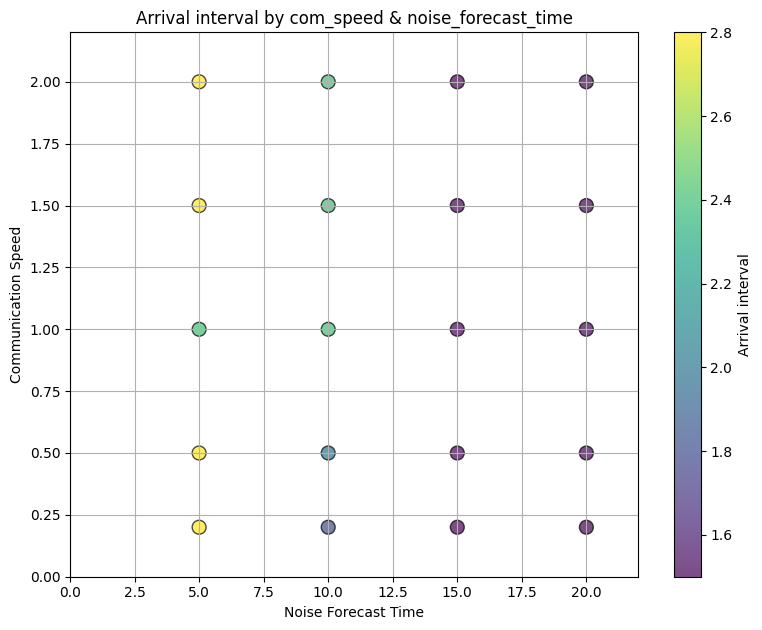

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

result_from_csv = pd.read_csv("result_df_without_v_mean.csv")

def plot_forecast_vs_speed(_df):
    # is_success が True のデータのみをフィルタリング
    successful_results = _df[(_df['is_success']) & (_df['type']=="dfr")]

    # 最小のdensityを取得するための辞書を作成
    min_density_by_forecast_and_speed = {}

    for _, row in successful_results.iterrows():
        key = (row['noise_forecast_time'], row['communication_speed'])
        if key not in min_density_by_forecast_and_speed:
            min_density_by_forecast_and_speed[key] = row['density']
        else:
            if row['density'] < min_density_by_forecast_and_speed[key]:
                min_density_by_forecast_and_speed[key] = row['density']

    # プロットの準備
    fig, ax = plt.subplots(figsize=(8, 6.4))

    # プロット用のリストを作成
    forecast_times = []
    comm_speeds = []
    min_densities = []

    for (forecast_time, comm_speed), min_density in min_density_by_forecast_and_speed.items():
        forecast_times.append(forecast_time)
        comm_speeds.append(comm_speed)
        min_densities.append(min_density)

    # 散布図をプロット
    scatter = ax.scatter(forecast_times, comm_speeds, c=min_densities, cmap='viridis', s=100, edgecolor='k', alpha=0.7)
    plt.colorbar(scatter, label='Arrival interval')

    ax.set_xlabel('Noise Forecast Time')
    ax.set_ylabel('Communication Speed')
    ax.set_title('Arrival interval by com_speed & noise_forecast_time')
    ax.grid(True)
    ax.set_ylim(0, 2.2)  # 縦軸の範囲を0から2.2までに設定
    ax.set_xlim(0, 22)  # 縦軸の範囲を0から2.2までに設定


    # グラフを表示
    plt.tight_layout()
    plt.show()

# 使用例
plot_forecast_vs_speed(result_from_csv)


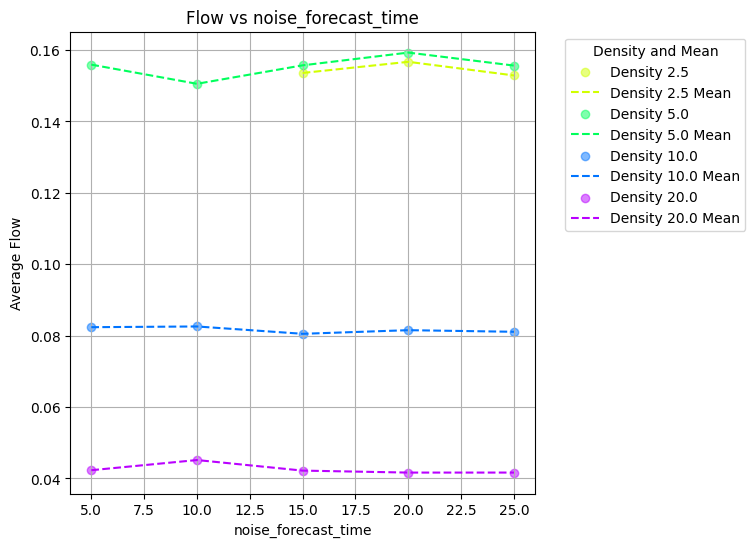

  type  density                                             v_mean  \
0  dfr     20.0  {0.002: 20.952614641995172, 0.0026666666666666...   
1  vfr     20.0  {0.0013333333333333333: 26.126724051992728, 0....   
2  dfr     10.0  {0.004: 21.10102730467694, 0.00466666666666666...   
3  vfr     10.0                                               None   
4  dfr      5.0  {0.006666666666666667: 19.879278846153845, 0.0...   

   noise_forecast_time  noise_period  communication_speed  is_success  \
0                    5             5                  0.2        True   
1                    5             5                  0.2        True   
2                    5             5                  0.2        True   
3                    5             5                  0.2        True   
4                    5             5                  0.2        True   

       flow  
0  0.047677  
1  0.046179  
2  0.084386  
3       NaN  
4  0.149299  


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def analyze_result(result_df, axis):
    # 平均流量を計算して 'flow' 列に追加
    def calculate_mean_flow(v_mean_dict):
        if v_mean_dict:
            total_flow = sum(density * speed for density, speed in v_mean_dict.items())
            mean_flow = total_flow / len(v_mean_dict)
            return mean_flow
        else:
            return None

    # 'flow' 列を計算して追加
    result_df['flow'] = result_df['v_mean'].apply(calculate_mean_flow)

    # is_success が True のデータのみをフィルタリングし、DFRだけに絞る
    dfr_results = result_df[(result_df['is_success']) & (result_df['type'] == 'dfr')& (result_df['communication_speed'] == 2) ]
    # dfr_results = result_df[(result_df['type'] == 'dfr') & (result_df['noise_forecast_time'] == 15)]

    grouped = dfr_results.groupby('density')


    # プロット
    plt.figure(figsize=(6, 6))
    colors = sns.color_palette("hsv", len(grouped))  # 密度ごとの色を指定
    for (density, group), color in zip(grouped, colors):
        plt.scatter(group[axis], group['flow'], color=color, alpha=0.5, label=f'Density {density}')
        mean_flow = group.groupby(axis)['flow'].mean()
        plt.plot(mean_flow.index, mean_flow.values, color=color, linestyle='--', label=f'Density {density} Mean')

    
    plt.xlabel(axis)
    plt.ylabel('Average Flow')
    plt.title(f'Flow vs {axis}')
    plt.grid(True)
    plt.legend(title="Density and Mean", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    return result_df

# 使い方の例:
# analyze_result(result_df, 'density')
df = analyze_result(result_df, 'noise_forecast_time')
print(df.head())


In [28]:
print(df.head)

  type  density                                             v_mean  \
0  dfr       20  {0.002: 21.41955223880597, 0.00266666666666666...   
1  vfr       20  {0.0013333333333333333: 28.910429369581912, 0....   
2  dfr       18  {0.0026666666666666666: 20.642469376391983, 0....   
3  vfr       18  {0.002: 25.540685351784756, 0.0013333333333333...   
4  dfr       20  {0.002: 21.067838827838827, 0.0026666666666666...   

   noise_forecast_time  noise_period  communication_speed  is_success  \
0                    5             5                  0.2        True   
1                    5             5                  0.2        True   
2                    5             5                  0.2        True   
3                    5             5                  0.2        True   
4                    5             5                  1.0        True   

       flow  
0  0.042264  
1  0.046762  
2  0.056597  
3  0.051449  
4  0.042102  


In [6]:
sys.stdout = original_stdout
vfr_simulation.conduct_simulation(should_plot=False)

Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

t=1.0, event_flg=arrival, noise=[]
t=10.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [20.0, 25.0]}]
t=22.5, event_flg=arrival, noise=[{'x': [420, 450], 't': [20.0, 25.0]}]
t=30.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [40.0, 45.0]}]
t=43.6, event_flg=arrival, noise=[{'x': [420, 450], 't': [40.0, 45.0]}]
t=50.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [60.0, 65.0]}]
t=65.60000000000001, event_flg=arrival, noise=[]
t=70.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [80.0, 85.0]}]
t=87.5, event_flg=arrival, noise=[]
t=90.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [100.0, 105.0]}]
t=108.4, event_flg=arrival, noise=[]
t=110.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [120.0, 125.0]}]
t=130.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [140.0, 145.0]}]
t=130.6, event_flg=arrival, noise=[{'x': [420, 450], 't': [140.0, 145.0]}]
t=150.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [160.0

In [6]:
# vfr_simulation.v_mean_log

In [12]:
# デバッグ用
cars = vfr_simulation.CARS
arrival_time = [car.arrival_time for car in cars ]
print(a)

[1.5747913067572927, 21.884781546599264, 43.57761751901193, 65.72947032936375, 87.71481304428235, 108.38870119472111, 128.66775903669526, 149.6319143917426, 169.8496563382233, 191.29332540198297, 212.20566913719142, 233.5853557619162, 254.21237695967878, 276.0895799103375, 296.70981143152346, 318.1552792239881, 339.79017486821664, 360.1846053681384, 380.8997579179795, 401.1219338621628, 401.7]


In [8]:
print(results)

[{'type': 'dfr', 'density': 20, 'v_mean': {0.012666666666666666: 20.777138157894736, 0.012: 20.555555555555557, 0.011333333333333334: 20.0, 0.010666666666666666: 20.0, 0.01: 20.0, 0.009333333333333334: 20.0, 0.008666666666666666: 20.0, 0.008: 20.0, 0.007333333333333333: 20.0, 0.006666666666666667: 20.025675675675675, 0.006: 20.766666666666666, 0.005333333333333333: 22.003345070422533, 0.004666666666666667: 23.428571428571427, 0.004: 23.47685185185185, 0.0033333333333333335: 23.6, 0.0026666666666666666: 22.25}}, {'type': 'vfr', 'density': 20, 'v_mean': {0.014: 8.984284216831387}}, {'type': 'dfr', 'density': 18, 'v_mean': {0.014: 20.857142857142858, 0.013333333333333334: 20.45, 0.012666666666666666: 20.0, 0.012: 20.0, 0.011333333333333334: 20.0, 0.010666666666666666: 20.0, 0.01: 20.0, 0.009333333333333334: 20.0, 0.008666666666666666: 20.0, 0.008: 20.0, 0.007333333333333333: 20.0, 0.006666666666666667: 20.0, 0.006: 20.0, 0.005333333333333333: 20.0, 0.004666666666666667: 20.0, 0.004: 20.0}

In [35]:
# print(arrival_time_log)

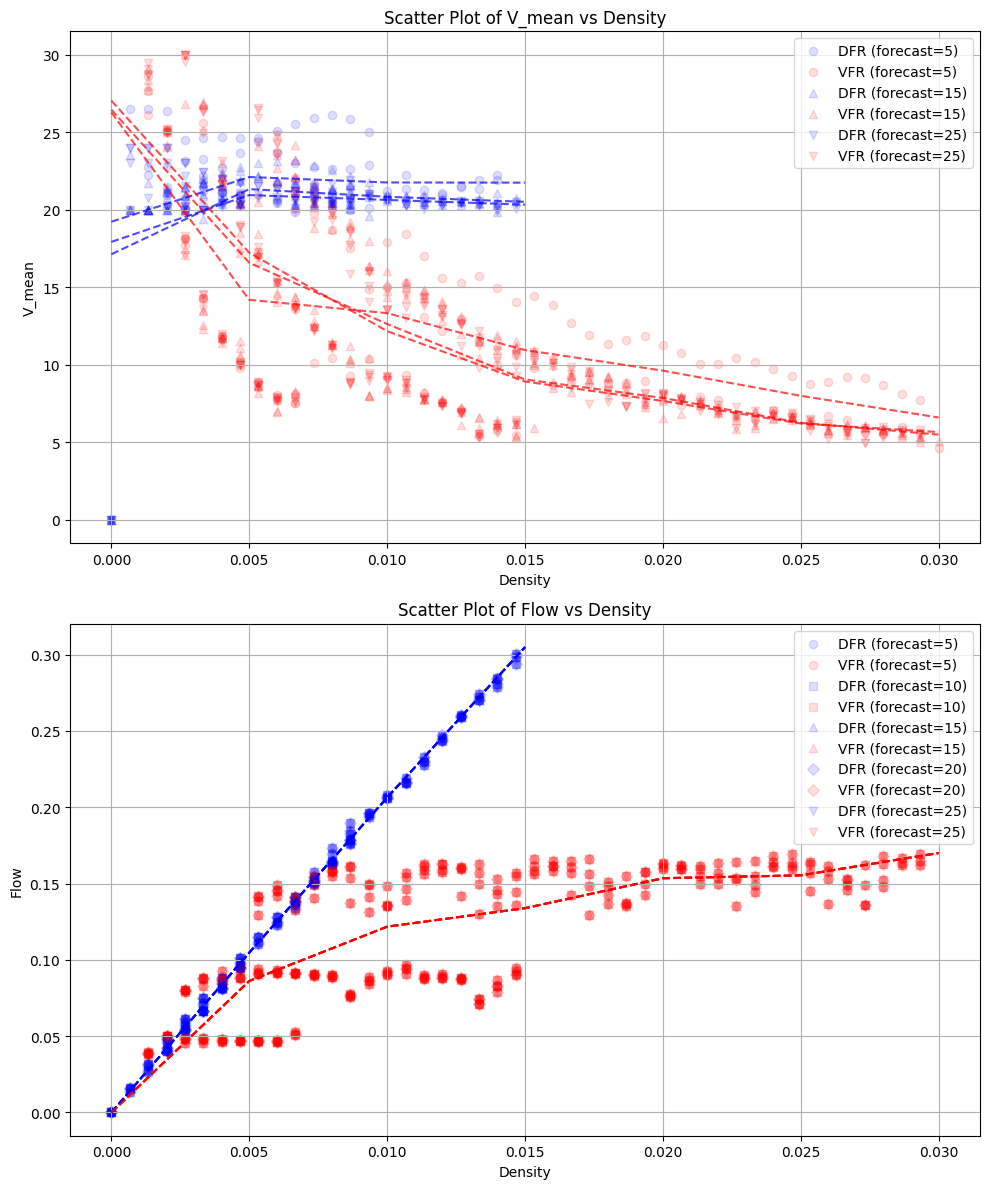

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_result(result_df):
    # is_success が True のデータのみをフィルタリング
    successful_results = result_df[result_df['is_success']]

    # noise_forecast_timeごとにデータを分ける
    noise_forecast_times = sorted(successful_results['noise_forecast_time'].unique())
    
    # マーカーの種類を指定
    markers = ['o', 's', '^', 'D', 'v']
    colors = ['blue', 'red']  # DFRとVFRで色を分ける

    # プロットの準備
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    for idx, noise_forecast_time in enumerate(noise_forecast_times):
        if noise_forecast_time in [10, 20]:
            continue
        dfr_data = {'density': [], 'v_mean': [], 'flow': []}
        vfr_data = {'density': [], 'v_mean': [], 'flow': []}

        # 各densityに対するv_meanの平均を計算するための辞書
        dfr_density_v_mean = defaultdict(list)
        vfr_density_v_mean = defaultdict(list)

        # noise_forecast_timeごとにフィルタリング
        filtered_results = successful_results[successful_results['noise_forecast_time'] == noise_forecast_time]

        for entry in filtered_results.to_dict(orient='records'):
            if entry['v_mean'] is not None:
                for density, v_mean in entry['v_mean'].items():
                    if entry['type'] == 'dfr':
                        dfr_data['density'].append(density)
                        dfr_data['v_mean'].append(v_mean)
                        dfr_data['flow'].append(density * v_mean)
                        dfr_density_v_mean[density].append(v_mean)
                    elif entry['type'] == 'vfr':
                        vfr_data['density'].append(density)
                        vfr_data['v_mean'].append(v_mean)
                        vfr_data['flow'].append(density * v_mean)
                        vfr_density_v_mean[density].append(v_mean)

        plot_densities = np.arange(0.00, 0.055, 0.005)

        def calculate_avg_per_density_interval(density_v_mean_dict, plot_densities):
            density_avg_v_mean = {}
            density_avg_flow = {}

            for target_density in plot_densities:
                lower_bound = target_density - 0.0025
                upper_bound = target_density + 0.0025

                # 密度範囲に入るデータをフィルタリング
                v_means_in_range = [v_mean for density, v_mean_list in density_v_mean_dict.items()
                                    if lower_bound < density <= upper_bound
                                    for v_mean in v_mean_list]

                if v_means_in_range:
                    avg_v_mean = np.mean(v_means_in_range)
                    density_avg_v_mean[target_density] = avg_v_mean
                    density_avg_flow[target_density] = target_density * avg_v_mean

            return density_avg_v_mean, density_avg_flow

        # DFRとVFRの平均計算
        dfr_density_avg_v_mean, dfr_density_avg_flow = calculate_avg_per_density_interval(dfr_density_v_mean, plot_densities)
        vfr_density_avg_v_mean, vfr_density_avg_flow = calculate_avg_per_density_interval(vfr_density_v_mean, plot_densities)

        # ソートしてリスト化
        dfr_density_sorted_v_mean = sorted(dfr_density_avg_v_mean.items())
        vfr_density_sorted_v_mean = sorted(vfr_density_avg_v_mean.items())

        dfr_density_sorted_flow = sorted(dfr_density_avg_flow.items())
        vfr_density_sorted_flow = sorted(vfr_density_avg_flow.items())

        # v_mean vs density
        axs[0].scatter(dfr_data['density'], dfr_data['v_mean'], color=colors[0], marker=markers[idx], label=f'DFR (forecast={noise_forecast_time})', alpha=0.13)
        axs[0].scatter(vfr_data['density'], vfr_data['v_mean'], color=colors[1], marker=markers[idx], label=f'VFR (forecast={noise_forecast_time})', alpha=0.13)

        # 平均線を引く
        axs[0].plot([item[0] for item in dfr_density_sorted_v_mean], [item[1] for item in dfr_density_sorted_v_mean], color=colors[0], linestyle='--', alpha=0.7)
        axs[0].plot([item[0] for item in vfr_density_sorted_v_mean], [item[1] for item in vfr_density_sorted_v_mean], color=colors[1], linestyle='--', alpha=0.7)

    axs[0].set_xlabel('Density')
    axs[0].set_ylabel('V_mean')
    axs[0].set_title('Scatter Plot of V_mean vs Density')
    axs[0].legend()
    axs[0].grid(True)

    for idx, noise_forecast_time in enumerate(noise_forecast_times):
        # flow vs density
        axs[1].scatter(dfr_data['density'], dfr_data['flow'], color=colors[0], marker=markers[idx], label=f'DFR (forecast={noise_forecast_time})', alpha=0.13)
        axs[1].scatter(vfr_data['density'], vfr_data['flow'], color=colors[1], marker=markers[idx], label=f'VFR (forecast={noise_forecast_time})', alpha=0.13)

        # 平均線を引く
        axs[1].plot([item[0] for item in dfr_density_sorted_flow], [item[1] for item in dfr_density_sorted_flow], color=colors[0], linestyle='--', alpha=0.7)
        axs[1].plot([item[0] for item in vfr_density_sorted_flow], [item[1] for item in vfr_density_sorted_flow], color=colors[1], linestyle='--', alpha=0.7)

    axs[1].set_xlabel('Density')
    axs[1].set_ylabel('Flow')
    axs[1].set_title('Scatter Plot of Flow vs Density')
    axs[1].legend()
    axs[1].grid(True)

    # グラフを表示
    plt.tight_layout()
    plt.savefig(f"./images/test_df_combined_totalTime={TOTAL_TIME}.png")
    plt.show()

# 使用例
plot_result(result_df)


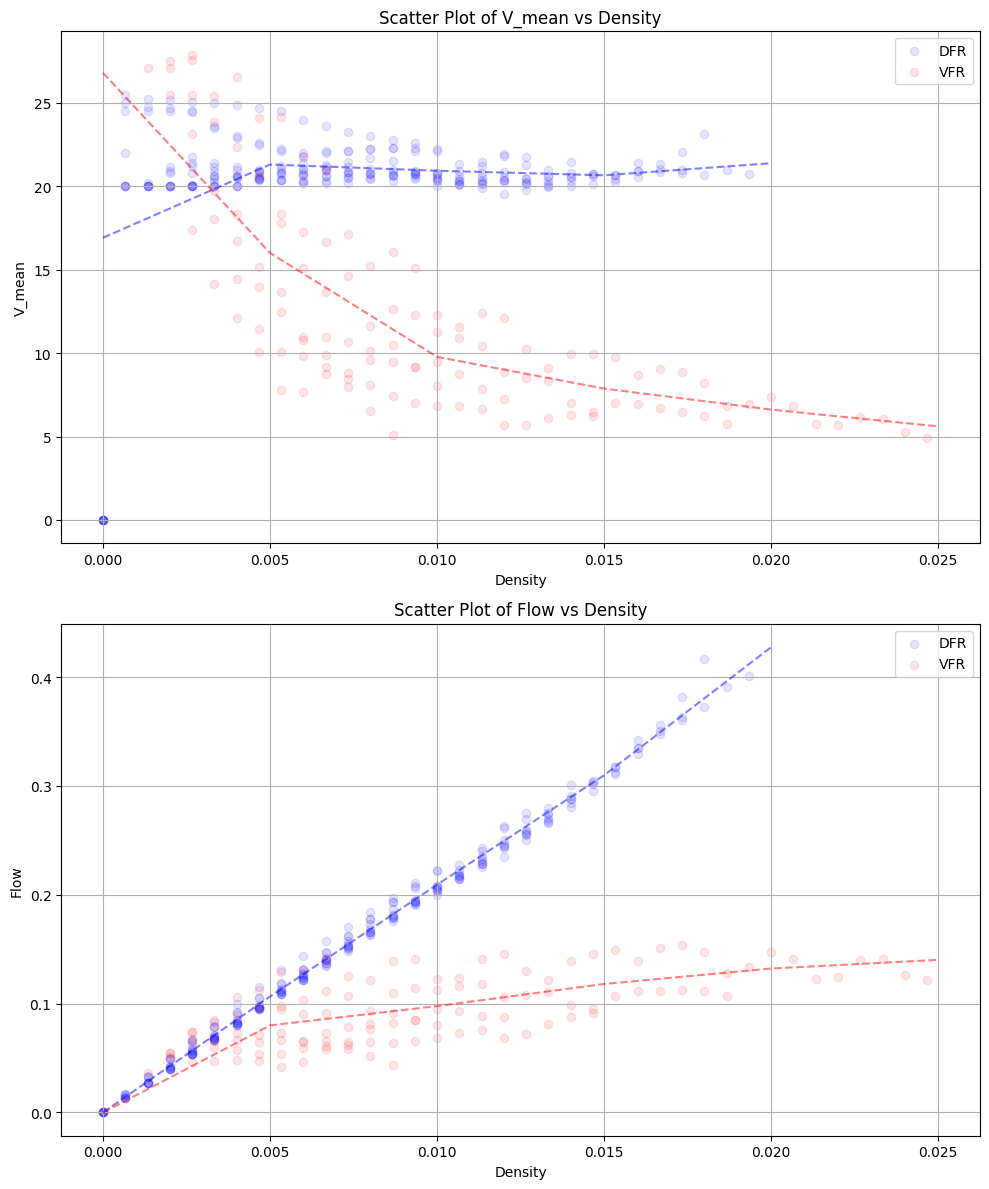

In [19]:
# result_dfではなくresultオブジェクトを使ったもの

dfr_data = {'density': [], 'v_mean': [], 'flow': []}
vfr_data = {'density': [], 'v_mean': [], 'flow': []}

# 各densityに対するv_meanの平均を計算するための辞書
dfr_density_v_mean = defaultdict(list)
vfr_density_v_mean = defaultdict(list)

for entry in results:
    if entry['v_mean'] is not None:
        for density, v_mean in entry['v_mean'].items():
            if entry['type'] == 'dfr':
                dfr_data['density'].append(density)
                dfr_data['v_mean'].append(v_mean)
                dfr_data['flow'].append(density * v_mean)
                dfr_density_v_mean[density].append(v_mean)
            elif entry['type'] == 'vfr':
                vfr_data['density'].append(density)
                vfr_data['v_mean'].append(v_mean)
                vfr_data['flow'].append(density * v_mean)
                vfr_density_v_mean[density].append(v_mean)

plot_densities = np.arange(0.00, 0.055, 0.005)

def calculate_avg_per_density_interval(density_v_mean_dict, plot_densities):
    density_avg_v_mean = {}
    density_avg_flow = {}

    for target_density in plot_densities:
        lower_bound = target_density - 0.0025
        upper_bound = target_density + 0.0025
        
        # 密度範囲に入るデータをフィルタリング
        v_means_in_range = [v_mean for density, v_mean_list in density_v_mean_dict.items()
                            if lower_bound < density <= upper_bound
                            for v_mean in v_mean_list]
        
        if v_means_in_range:
            avg_v_mean = np.mean(v_means_in_range)
            density_avg_v_mean[target_density] = avg_v_mean
            density_avg_flow[target_density] = target_density * avg_v_mean

    return density_avg_v_mean, density_avg_flow


# DFRとVFRの平均計算
dfr_density_avg_v_mean, dfr_density_avg_flow = calculate_avg_per_density_interval(dfr_density_v_mean, plot_densities)
vfr_density_avg_v_mean, vfr_density_avg_flow = calculate_avg_per_density_interval(vfr_density_v_mean, plot_densities)


# ソートしてリスト化
dfr_density_sorted_v_mean = sorted(dfr_density_avg_v_mean.items())
vfr_density_sorted_v_mean = sorted(vfr_density_avg_v_mean.items())

dfr_density_sorted_flow = sorted(dfr_density_avg_flow.items())
vfr_density_sorted_flow = sorted(vfr_density_avg_flow.items())

# プロット
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# v_mean vs density
axs[0].scatter(dfr_data['density'], dfr_data['v_mean'], color='blue', label='DFR', alpha=0.1)
axs[0].scatter(vfr_data['density'], vfr_data['v_mean'], color='red', label='VFR', alpha=0.1)

# 平均線を引く
axs[0].plot([item[0] for item in dfr_density_sorted_v_mean], [item[1] for item in dfr_density_sorted_v_mean], color='blue', linestyle='--', alpha=0.5)
axs[0].plot([item[0] for item in vfr_density_sorted_v_mean], [item[1] for item in vfr_density_sorted_v_mean], color='red', linestyle='--', alpha=0.5)

axs[0].set_xlabel('Density')
axs[0].set_ylabel('V_mean')
axs[0].set_title('Scatter Plot of V_mean vs Density')
axs[0].legend()
axs[0].grid(True)

# flow vs density
axs[1].scatter(dfr_data['density'], dfr_data['flow'], color='blue', label='DFR', alpha=0.1)
axs[1].scatter(vfr_data['density'], vfr_data['flow'], color='red', label='VFR', alpha=0.1)

# 平均線を引く
axs[1].plot([item[0] for item in dfr_density_sorted_flow], [item[1] for item in dfr_density_sorted_flow], color='blue', linestyle='--', alpha=0.5)
axs[1].plot([item[0] for item in vfr_density_sorted_flow], [item[1] for item in vfr_density_sorted_flow], color='red', linestyle='--', alpha=0.5)


axs[1].set_xlabel('Density')
axs[1].set_ylabel('Flow')
axs[1].set_title('Scatter Plot of Flow vs Density')
axs[1].legend()
axs[1].grid(True)

# グラフを表示
plt.tight_layout()
plt.savefig(f"./images/n_period={NOISE_PERIOD}_n_forecast={NOISE_FORECAST_TIME}_n_freq={NOISE_FREQUENCY}_totalTime={TOTAL_TIME}.png")
plt.show()


In [16]:
vlog = simulation.v_mean_log
print(vlog[300:340])
table = simulation.reservation_table.eta_table
print(table[table["car_idx"] == 0])

[{'time': 33.0, 'v_mean': 20.04736842105263, 'density': 0.019, 'event_flg': None}, {'time': 33.1, 'v_mean': 20.031578947368423, 'density': 0.019, 'event_flg': None}, {'time': 33.2, 'v_mean': 20.01578947368421, 'density': 0.019, 'event_flg': None}, {'time': 33.300000000000004, 'v_mean': 20.0, 'density': 0.019, 'event_flg': None}, {'time': 33.4, 'v_mean': 19.98421052631579, 'density': 0.019, 'event_flg': None}, {'time': 33.5, 'v_mean': 19.968421052631577, 'density': 0.019, 'event_flg': None}, {'time': 33.6, 'v_mean': 19.95263157894737, 'density': 0.019, 'event_flg': None}, {'time': 33.7, 'v_mean': 19.936842105263157, 'density': 0.019, 'event_flg': None}, {'time': 33.800000000000004, 'v_mean': 19.92105263157895, 'density': 0.019, 'event_flg': None}, {'time': 33.9, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': None}, {'time': 34.0, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': None}, {'time': 34.1, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': N

[20.300000000000004, 20.599999999999994, 20.9, 21.20000000000001, 21.500000000000004, 21.800000000000015, 22.10000000000001, 22.40000000000002, 22.699999999999996, 23.000000000000007, 23.30000000000002, 23.599999999999994, 23.900000000000006, 24.200000000000017, 24.499999999999993, 24.80000000000004, 24.933763884510753, 25.00205455537177, 25.045066351248195, 25.078284478181345, 25.107649150798323, 25.13543427568102, 25.162509497197192, 25.189207542893186, 25.21565612084416, 25.241904739377077, 25.26797310634123, 25.29386957926704, 25.319598191088915, 25.34516132271463, 25.37056071867525, 25.39579787278342, 25.420874174509436, 25.44579096457028, 25.470549556103492, 25.49515124281058, 25.51959730216808, 25.54388899677207, 25.568027574976497, 25.592014271262684, 25.615850306503347, 25.639536888187706, 25.66307521062626, 25.686466455148178, 25.709711790291863, 25.73281237199282, 26.032812371992833, 26.332812371992844, 26.632812371992856, 26.932812371992867, 27.23281237199288, 27.5328123719

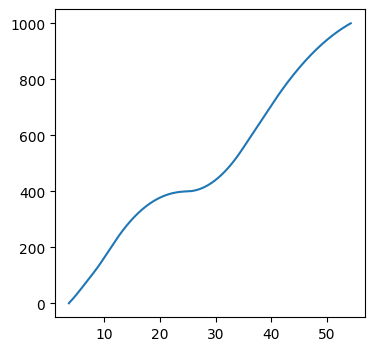

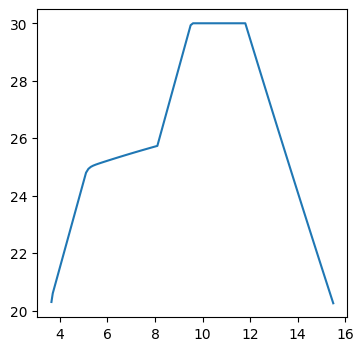

In [15]:
cars = vfr_simulation.CARS
car_0 = cars[1]
xcors = car_0.xcorList
plt.figure(figsize = (4,4))
plt.plot(car_0.timeLog, car_0.xcorList)

vList = []
for i in range(len(xcors)-1):
    v = (xcors[i+1] - xcors[i]) * 10
    vList.append(v)

print(vList[:120])

plt.figure(figsize=(4,4))
plt.plot(car_0.timeLog[:120], vList[:120])



In [14]:
# 動画作成
import cv2
import os
import re

# カレントディレクトリを取得
current_dir = os.getcwd()
# 画像フォルダのパス
image_folder = os.path.join(current_dir, 'images/dfr/example_0927/共有用')
video_file = f'test.mp4'

# 正規表現でファイル名からtの値を抽出
def extract_t(filename):
    match = re.search(r't=(\d+\.\d+)', filename)
    if match:
        return float(match.group(1))
    return None

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: extract_t(x))

# 画像から動画を作成
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# 動画ライターを設定
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_file, fourcc, 5, (width, height))  # フレームレートを5fpsに設定

for image in images:
    print(image)
    video.write(cv2.imread(os.path.join(image_folder, image)))

# リソースを解放
cv2.destroyAllWindows()
video.release()

dfr_simulation_t=2.5.png
dfr_simulation_t=3.0.png
dfr_simulation_t=3.5.png
dfr_simulation_t=4.0.png
dfr_simulation_t=4.5.png
dfr_simulation_t=5.0.png
dfr_simulation_t=5.5.png
dfr_simulation_t=6.0.png
dfr_simulation_t=6.4.png
dfr_simulation_t=6.5.png
dfr_simulation_t=7.0.png
dfr_simulation_t=7.5.png
dfr_simulation_t=8.0.png
dfr_simulation_t=8.5.png
dfr_simulation_t=9.0.png
dfr_simulation_t=9.5.png
dfr_simulation_t=10.0.png
dfr_simulation_t=10.5.png
dfr_simulation_t=11.0.png
dfr_simulation_t=11.5.png
dfr_simulation_t=12.0.png
dfr_simulation_t=12.5.png
dfr_simulation_t=13.0.png
dfr_simulation_t=13.5.png
dfr_simulation_t=13.8.png
dfr_simulation_t=14.0.png
dfr_simulation_t=14.5.png
dfr_simulation_t=15.0.png
dfr_simulation_t=15.5.png
dfr_simulation_t=16.0.png
dfr_simulation_t=16.5.png
dfr_simulation_t=17.0.png
dfr_simulation_t=17.5.png
dfr_simulation_t=18.0.png
dfr_simulation_t=18.5.png
dfr_simulation_t=19.0.png
dfr_simulation_t=19.4.png
dfr_simulation_t=19.5.png
dfr_simulation_t=20.0.png
df

# ここから下はDebug用のセル

In [27]:
# ↑の DFRのシミュレーションでつっかえた時のデバッグ用のセル. これは適宜上に上げて良い

car_1 = CARS[14]
print("ETA",car_1.my_etas)
print("===  acc_itinerary =====")
print(car_1.acc_itinerary)
print(car_1.xcor)
print(car_1.v_x)

# print("acc:",car.acc_itinerary)
# table = simulation.reservation_table.eta_table
# print(table[table["car_idx"]<=4])

IndexError: list index out of range

In [7]:
import sys 
sys.path.append("../")
from utils.calc_distance_from_acc_itinerary import calc_distance_from_acc_itinerary
acc_itinerary = [{'acc': 0, 't_start': 29.113823476836664, 'v_0': 20, 't_end': 32.6, 'x_start': 0}, {'t_start': 32.6, 'acc': -3, 'v_0': 20.0, 't_end': 33.1}, {'t_start': 33.1, 'acc': 0, 'v_0': 18.5, 't_end': 45.120270270270275}, {'t_start': 45.120270270270275, 'acc': -3, 'v_0': 18.5, 't_end': 45.620270270270275}, {'t_start': 45.620270270270275, 'acc': 0, 'v_0': 17.0, 't_end': 52.745270270270275}, {'t_start': 52.745270270270275, 'acc': 2, 'v_0': 17.0, 't_end': 53.745270270270275}, {'t_start': 53.745270270270275, 'acc': 0, 'v_0': 19.0, 't_end': 56.804093799682036}, {'t_start': 56.804093799682036, 'acc': 2, 'v_0': 19.0, 't_end': 60.804093799682036}, {'t_start': 60.804093799682036, 'acc': 0, 'v_0': 27.0, 't_end': 60.90316500711238}]
x = calc_distance_from_acc_itinerary(acc_itinerary, 53)
print(x)

436.1188231038803


In [6]:
def calc_x_at_pointed_time(pointed_time, carObj, current_time):
    acc_itinerary = carObj.acc_itinerary
    car_x = carObj.xcor
    # print(carObj.xcor, carObj.acc_itinerary)
    v_0 = carObj.v_x
    acc_itinerary_with_tend = carObj.acc_itinerary
    # print(f"carId: {carObj.car_idx}, acc_itinerary: {acc_itinerary_with_tend}")

    if len(acc_itinerary_with_tend) < 1:
        raise ValueError("acc_itinerary is empty")
    if len(acc_itinerary_with_tend) == 1:
        delta_t = pointed_time - current_time
        delta_x = v_0 * delta_t + 0.5 * acc_itinerary_with_tend[0]["acc"] * delta_t**2 + car_x
        return delta_x
    
    # 長さ2以上の場合
    for idx, accObj in enumerate(acc_itinerary_with_tend):
        if accObj["t_end"] < current_time:
            continue

        # この区間を全うできる場合.
        elif accObj["t_end"] <= pointed_time:
            delta_t = accObj["t_end"] - accObj["t_start"]
            if accObj["t_start"] < current_time:
                delta_t = accObj["t_end"] - current_time
            delta_x = v_0 * delta_t + 0.5 * accObj["acc"] * delta_t**2
            car_x += delta_x
            v_0 += delta_t * accObj["acc"]

        # 一番最後の区間の場合
        elif idx == len(acc_itinerary) - 1 or accObj["t_end"] > pointed_time:
            delta_t = pointed_time - accObj["t_start"]
            if accObj["t_start"] < current_time:
                delta_t = accObj["t_end"] - current_time
            delta_x = v_0 * delta_t + 0.5 * accObj["acc"] * delta_t**2
            car_x += delta_x
            break
        else:
            print(accObj, current_time, pointed_time, carObj.car_idx)
            raise ValueError("Something wrong")

    return car_x

calc_x_at_pointed_time(53, car_1, 48)

442.42488723520705